In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
# Configure the map plot
import hvplot.pandas
import holoviews as hv
from holoviews import opts
import seaborn as sns

# Import API key
from api_keys import geoapify_key

### Cleaning the data

In [2]:
# Load the CSV file into a Pandas DataFrame
Airbnb_data_df = pd.read_csv("Resources/listingss.csv")

# Drop unnecessary columns
data = Airbnb_data_df.drop(columns=["id","neighbourhood_group","license","host_id","host_name"])
# Remove rows with missing or unrealistic values
data = data.dropna(subset=["name", "neighbourhood"])
data = data[data["price"] > 0]


# Display sample data
data.head()

,name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,"Lovely large room, Bethnal Green",Tower Hamlets,51.52874,-0.05396,Private room,55,3,65,2016-06-10,0.47,1,74,0
1,Holiday London DB Room Let-on going,Islington,51.56861,-0.11270,Private room,50,1,30,2022-07-15,0.20,2,343,9
2,COSY STUDIO-FLAT WITH A GREAT VIEW,Tower Hamlets,51.52851,-0.07426,Entire home/apt,90,5,42,2022-01-04,0.34,1,222,1
3,A Luxury Studio Suite in Clerkenwell,Islington,51.52478,-0.10484,Private room,180,4,493,2022-09-02,3.59,5,236,20
4,Notting Hill church stay in Heaven!,Kensington and Chelsea,51.51464,-0.20004,Entire home/apt,297,14,6,2022-07-04,0.05,1,180,2


### 1. Plot all the data on a map to visulize the data for Location Analysis

In [3]:
# Display the map
# Configure the map plot
map_plot = data.hvplot.points(
    'longitude',
    'latitude',
    geo = True,
    tiles = 'OSM',
    frame_width = 700,
    frame_height = 500,
    color='price',
    alpha = 0.5
)

map_plot.opts(opts.Points(size=1, width=600, height=400))

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]   (price)

**What this shows**: The map visually illustrates that as one moves further away from the central point, the density of Airbnb listings gradually decreases. This observation indicates a higher concentration of Airbnb listings in the central areas of the city. In other words, the central regions exhibit a more significant presence of Airbnb accommodations, while the number of listings diminishes as we venture towards the city's outskirts. This spatial distribution highlights the popularity and demand for Airbnb rentals in the city's central zones, possibly due to proximity to attractions, amenities, or transportation hubs.

### 2. Create a Df to show the top 50 airbnbs depending on their **Price** to see if their location effects the price

In [4]:
top_50 = data.sort_values(by="price", ascending=False).head(50)
top_50.head()

,name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
64450,"Big Single Room Near Stratford, East London",Newham,51.550677,0.011295,Private room,25000,2,0,NaN,NaN,2,26,0
34036,"Budget single room near Stratford, East London",Newham,51.550340,0.009320,Private room,23000,2,28,2022-08-24,2.33,2,18,28
23979,Stratford Saffron Apartment,Newham,51.546240,0.006890,Entire home/apt,20362,1,8,2022-03-20,0.17,1,90,3
50838,—,Kensington and Chelsea,51.491950,-0.167840,Entire home/apt,20000,150,0,NaN,NaN,1,364,0
43590,Beautiful Studio in London near Wimbledon Park,Wandsworth,51.425820,-0.166950,Entire home/apt,18202,1,0,NaN,NaN,9,365,0


In [5]:
# Display the map
# Configure the map plot
map_plot1 = top_50.hvplot.points(
    'longitude',
    'latitude',
    geo = True,
    tiles = 'OSM',
    frame_width = 700,
    frame_height = 500,
    color='price',
)

map_plot1.opts(opts.Points(size=10, width=600, height=400))

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]   (price)

**What this shows**: From this data we can see that these a stong pull to the center of the london

### create a dataframe that makes a column that shows the distance of the Airbnb relitive to the center 

In [6]:

# Define the latitude and longitude of the center of London
center_latitude = 51.509865  # Latitude of the center
center_longitude = -0.118092  # Longitude of the center

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    radius = 6371  # Earth's radius in kilometers
    distance = radius * c
    
    return distance

# Create a new column 'distance_to_center' in your DataFrame to store the distances
top_50['distance_to_center'] = top_50.apply(lambda row: haversine(center_latitude, center_longitude, row['latitude'], row['longitude']), axis=1)

# Display the DataFrame with the added distance column
top_50[['name', 'neighbourhood', 'latitude', 'longitude', 'distance_to_center']].head()

,name,neighbourhood,latitude,longitude,distance_to_center
64450,"Big Single Room Near Stratford, East London",Newham,51.550677,0.011295,10.035031
34036,"Budget single room near Stratford, East London",Newham,51.550340,0.009320,9.896295
23979,Stratford Saffron Apartment,Newham,51.546240,0.006890,9.545301
50838,—,Kensington and Chelsea,51.491950,-0.167840,3.978198
43590,Beautiful Studio in London near Wimbledon Park,Wandsworth,51.425820,-0.166950,9.939314


### The next cell is to see how many of the airbnbs are less then 10km

In [7]:
# Filter the Airbnb listings where the distance to the center is below 10 kilometers
filtered_data = top_50[top_50['distance_to_center'] < 10]

# Display the filtered DataFrame
print(len(filtered_data))

46


**What this shows**: this shows that 46/50 of the point are less then 10km 

### 3. next will create a Df on the cheapest Airbnbs 

In [8]:
bottom_50 = data.sort_values(by="price").head(50)
bottom_50.head()

,name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
47953,Hoxton Co-Living apartment with living room,Hackney,51.532423,-0.073847,Private room,1,30,0,NaN,NaN,9,345,0
26265,Small double bedroom near Tooting Broadway,Merton,51.416600,-0.160260,Private room,7,1,0,NaN,NaN,1,0,0
24642,Shared room,Croydon,51.354910,-0.067370,Shared room,7,1,0,NaN,NaN,1,0,0
48091,LuxNomads Lavish Penthouse SkyLine View,Southwark,51.497840,-0.074240,Entire home/apt,8,3,20,2022-07-19,1.26,4,0,18
13094,Joslings Place,Hammersmith and Fulham,51.515030,-0.236540,Private room,8,1,0,NaN,NaN,2,0,0


In [9]:
# Display the map
# Configure the map plot
map_plot = bottom_50.hvplot.points(
    'longitude',
    'latitude',
    geo = True,
    tiles = 'OSM',
    frame_width = 700,
    frame_height = 500,
    color='price',
    alpha = 0.5
)

map_plot.opts(opts.Points(size=10, width=600, height=400))

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]   (price)

In [10]:

# Define the latitude and longitude of the center of London
center_latitude = 51.509865  # Latitude of the center
center_longitude = -0.118092  # Longitude of the center

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    radius = 6371  # Earth's radius in kilometers
    distance = radius * c
    
    return distance

# Create a new column 'distance_to_center' in your DataFrame to store the distances
bottom_50['distance_to_center'] = bottom_50.apply(lambda row: haversine(center_latitude, center_longitude, row['latitude'], row['longitude']), axis=1)

# Display the DataFrame with the added distance column
bottom_50[['name', 'neighbourhood', 'latitude', 'longitude', 'distance_to_center']].head()

,name,neighbourhood,latitude,longitude,distance_to_center
47953,Hoxton Co-Living apartment with living room,Hackney,51.532423,-0.073847,3.957655
26265,Small double bedroom near Tooting Broadway,Merton,51.416600,-0.160260,10.774177
24642,Shared room,Croydon,51.354910,-0.067370,17.585329
48091,LuxNomads Lavish Penthouse SkyLine View,Southwark,51.497840,-0.074240,3.316673
13094,Joslings Place,Hammersmith and Fulham,51.515030,-0.236540,8.216882


In [11]:
# Filter the Airbnb listings where the distance to the center is below 10 kilometers
filtered_data2 = bottom_50[bottom_50['distance_to_center'] < 10]

# Display the filtered DataFrame
print(len(filtered_data2))

23


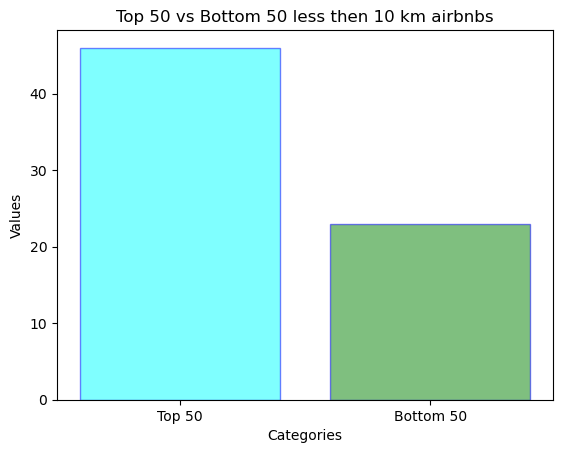

In [12]:
# Create a bar chart
# Create labels for the bars
labels = ['Top 50', 'Bottom 50']

# Specify different colors for each bar
colors = ['cyan', 'green']
plt.bar(labels,[len(filtered_data), len(filtered_data2)],color=colors,alpha=0.5,edgecolor ='blue')

# Add a title and labels
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Top 50 vs Bottom 50 less then 10 km airbnbs')

# Show the bar chart
plt.show()

**What this shows**:The impact of location on Airbnb prices in London is strikingly evident in our analysis. Out of the top 50 Airbnb listings, an overwhelming 46 of them are located within a 10-kilometer radius from the central point of London. This concentration of high-priced listings near the city center suggests that proximity to central attractions, amenities, and transportation hubs significantly influences pricing in the upper tier.

Conversely, among the bottom 50 listings, only 23 of them are found within the same 10-kilometer radius from the center of London. This disparity indicates that listings located farther from the city center tend to have lower prices. It's plausible that these listings cater to budget-conscious travelers or offer accommodations in areas with less demand, leading to more competitive pricing.

Overall, the data underscores the strong correlation between proximity to central London and Airbnb pricing, with listings closer to the center generally commanding higher rates. This insight can be invaluable for both hosts and travelers seeking to understand the pricing dynamics within London's Airbnb market

### 4. plot data to see if the neigbourhood effects the price to further prove Location is a major factor

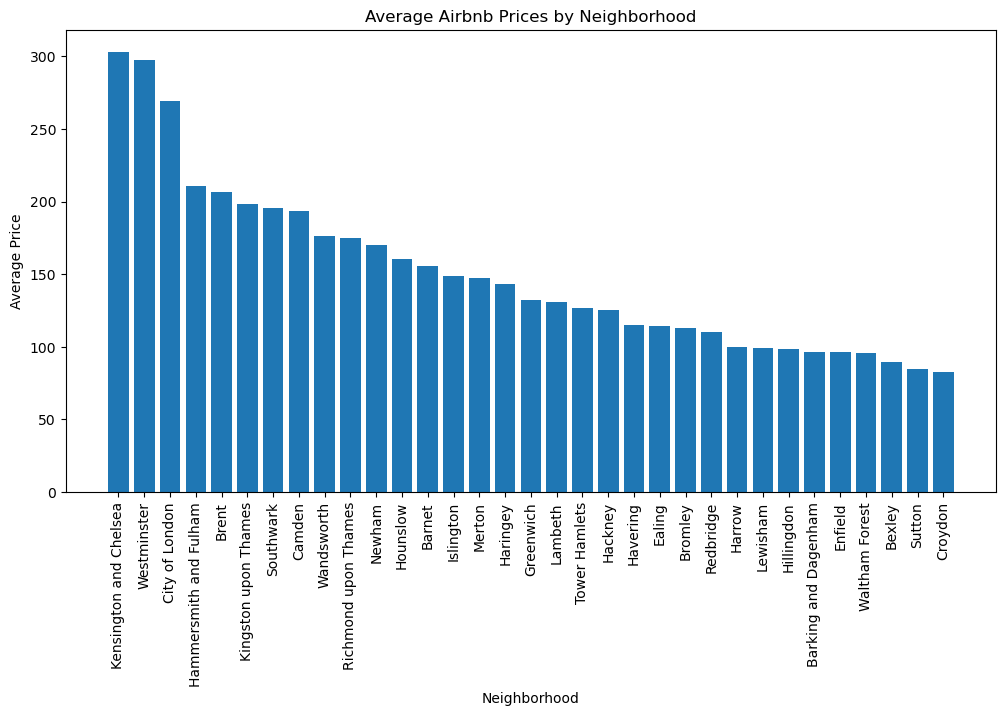

In [13]:
neighborhood_stats = data.groupby('neighbourhood')['price'].agg(['mean', 'median', 'min', 'max']).reset_index()
neighborhood_stats = neighborhood_stats.sort_values(by='mean', ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(neighborhood_stats['neighbourhood'], neighborhood_stats['mean'])
plt.xlabel('Neighborhood')
plt.ylabel('Average Price')
plt.title('Average Airbnb Prices by Neighborhood')
plt.xticks(rotation=90)
plt.show()

**What this shows**: The insights derived from the bar chart portraying the average price of Airbnb listings across various neighborhoods are striking. The data unequivocally reveals that Kensington and Chelsea stand out with the highest average listing prices, while Croydon emerges as the neighborhood offering the most budget-friendly options. This stark contrast in pricing among neighborhoods underscores the profound influence of location on determining the average price of Airbnb accommodations in London.

Kensington and Chelsea, known for its upscale appeal and proximity to prestigious landmarks, commands a premium in the Airbnb market. Travelers seeking luxurious and well-situated lodgings can expect to pay a premium in this affluent neighborhood. Conversely, Croydon, situated further from the city center and characterized by a more cost-effective housing landscape, offers more budget-friendly alternatives.

This analysis underscores the significance of neighborhood choice as a pivotal factor impacting the average price of Airbnb listings. It highlights the importance of aligning one's accommodation preferences with their budget and desired location, as London's diverse neighborhoods offer a wide spectrum of pricing options to cater to various traveler preferences.

### 4. Plot data using groupby to see if the "Room type" effects the avarge price of the Airbnbs

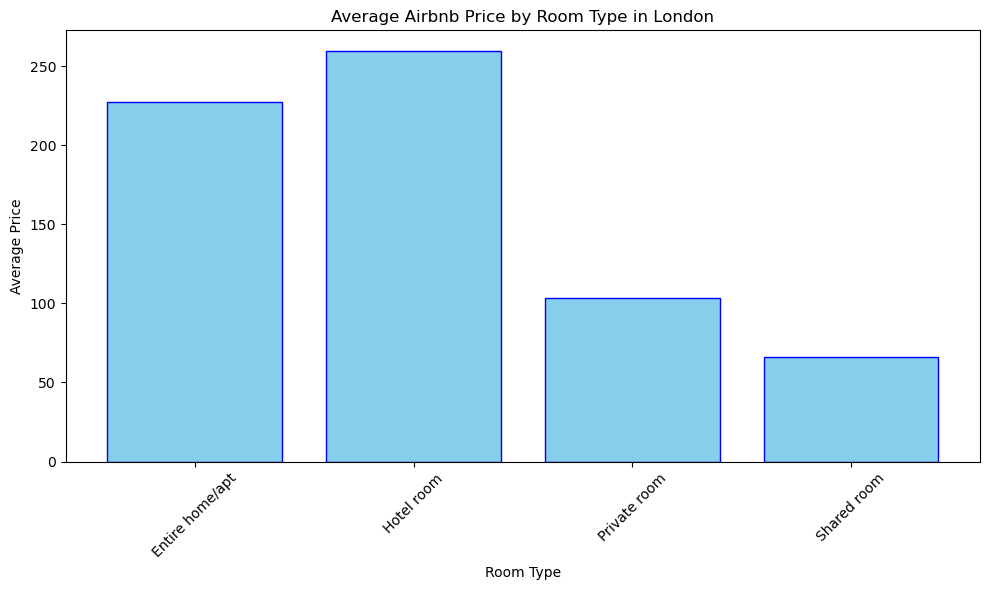

In [14]:
room_type_prices = data.groupby('room_type')['price'].mean().reset_index()

# Create a bar chart to visualize the average prices by room type
plt.figure(figsize=(10, 6))
plt.bar(room_type_prices['room_type'], room_type_prices['price'], color='skyblue',edgecolor ='blue')
plt.xlabel('Room Type')
plt.ylabel('Average Price')
plt.title('Average Airbnb Price by Room Type in London')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()
plt.show()

**What this shows**:Our analysis reveals a distinct correlation between room types and the average prices of Airbnb listings in London. By examining the data, we observe a clear pattern: Hotel rooms command the highest average prices, followed by Entire homes, Private rooms, and Shared rooms, in that order.

This trend suggests that the type of accommodation significantly impacts the pricing structure in the Airbnb market. Hotel rooms, known for their premium amenities and services, tend to come with the highest price tags. Entire homes, which offer guests a private and complete living space, come in as the second most expensive option. Private rooms, which offer privacy within a shared home or apartment, are generally more affordable than entire homes but still more expensive than shared rooms. Shared rooms, often characterized by shared spaces and bunk beds, are the most budget-friendly choice, resulting in the lowest average prices.

This insight can be valuable for both Airbnb hosts and travelers, as it provides a better understanding of the pricing dynamics within different room types. Hosts may adjust their pricing strategies based on room type, while travelers can make more informed decisions when selecting accommodations that align with their budget and preferences.

### 5.5 The following is display the usage of Apis

In [15]:
# Define your Geoapify API key here
api_key = geoapify_key

# DataFrame with neighborhood data
#neighborhood_stats = data.groupby('neighbourhood')['price'].agg(['mean', 'median', 'min', 'max']).reset_index()
#neighborhood_stats = neighborhood_stats.sort_values(by='mean', ascending=False)

# Initialize empty lists to store latitude and longitude
latitude_list = []
longitude_list = []

# Print to logger
print("Beginning Data Retrieval     ")
print("-----------------------------")

# Define a function to get coordinates from Geoapify
def get_coordinates(neighborhood):
    url = f"https://api.geoapify.com/v1/geocode/search?text={neighborhood}, London, United Kingdom&filter=circle:-0.0976948320600286,51.54049581786134,70000&apiKey={api_key}"
    response = requests.get(url)
    data2 = response.json()
    if data2['features']:
        location = data2['features'][0]['geometry']['coordinates']
        return location[1], location[0]  # Return latitude and longitude
    else:
        return None, None
    
# Apply the get_coordinates function to each neighborhood
for neighborhood in neighborhood_stats['neighbourhood']:
    lat, lon = get_coordinates(neighborhood)
    latitude_list.append(lat)
    longitude_list.append(lon)
    print(neighborhood, "Found data"  )
# Indicate that Data Loading is complete 
print("-----------------------------")
print("Data Retrieval Complete      ")
print("-----------------------------")
# Add latitude and longitude columns to the DataFrame
neighborhood_stats['latitude'] = latitude_list
neighborhood_stats['longitude'] = longitude_list

Beginning Data Retrieval     
-----------------------------
Kensington and Chelsea Found data
Westminster Found data
City of London Found data
Hammersmith and Fulham Found data
Brent Found data
Kingston upon Thames Found data
Southwark Found data
Camden Found data
Wandsworth Found data
Richmond upon Thames Found data
Newham Found data
Hounslow Found data
Barnet Found data
Islington Found data
Merton Found data
Haringey Found data
Greenwich Found data
Lambeth Found data
Tower Hamlets Found data
Hackney Found data
Havering Found data
Ealing Found data
Bromley Found data
Redbridge Found data
Harrow Found data
Lewisham Found data
Hillingdon Found data
Barking and Dagenham Found data
Enfield Found data
Waltham Forest Found data
Bexley Found data
Sutton Found data
Croydon Found data
-----------------------------
Data Retrieval Complete      
-----------------------------


In [16]:
# Display the map
# Configure the map plot
map_plot5 = neighborhood_stats.hvplot.points(
    'longitude',
    'latitude',
    geo = True,
    tiles = 'OSM',
    frame_width = 700,
    frame_height = 500,
)

map_plot5.opts(opts.Points(size=10, width=600, height=400))

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]

**What this shows**: This demonstrates the utilization of Geoapify to retrieve data for each neighborhood in London and the capability to subsequently visualize this data on a map.

### 6. The following shows Number of reviews agaisnt price

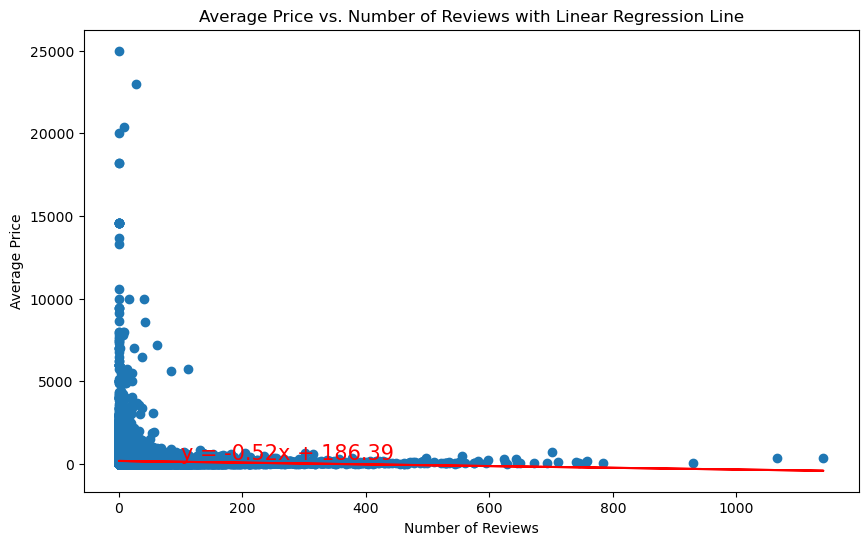

In [18]:
# Add the linear regression equation and line to the plot
x_values = average_price_by_reviews['number_of_reviews']
y_values = average_price_by_reviews['price']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values)
plt.plot(x_values, regress_values, "r-")
plt.annotate(line_eq, (100, 250), fontsize=15, color="red")
plt.xlabel('Number of Reviews')
plt.ylabel('Average Price')
plt.title('Average Price vs. Number of Reviews with Linear Regression Line')
plt.show()


**What this shows**:Upon visual examination of the scatter plot, it becomes evident that there is no significant correlation between the average price and the number of reviews. The data points on the graph are widely dispersed and do not exhibit any discernible pattern. They are scattered across the plot without any clear trend.
The slope of the regression line, which is approximately -0.02, indicates a very slight negative relationship. However, this slope is close to zero, suggesting that changes in the number of reviews have an almost negligible impact on the average price.
It's worth noting that while this analysis focuses on the number of reviews, the content and sentiment of those reviews could potentially reveal a different story. If data were available to analyse the content of reviews and determine sentiment (e.g., positive, negative, or neutral), it might show a more meaningful correlation between the sentiment of reviews and the average price. Positive reviews, for instance, could be associated with higher prices, while negative reviews might correlate with lower prices.
In summary, the scatter plot and regression line for average price vs. the number of reviews do not provide strong evidence of a meaningful correlation. The data points' wide dispersion and the regression line's nearly flat slope suggest that factors beyond the number of reviews are influencing the average price of Airbnb listings. Additional variables, such as the content and sentiment of reviews, location, property type, and amenities, may have a more substantial impact on pricing decisions.


### 7. The following shows Number Availabilty agaisnt price

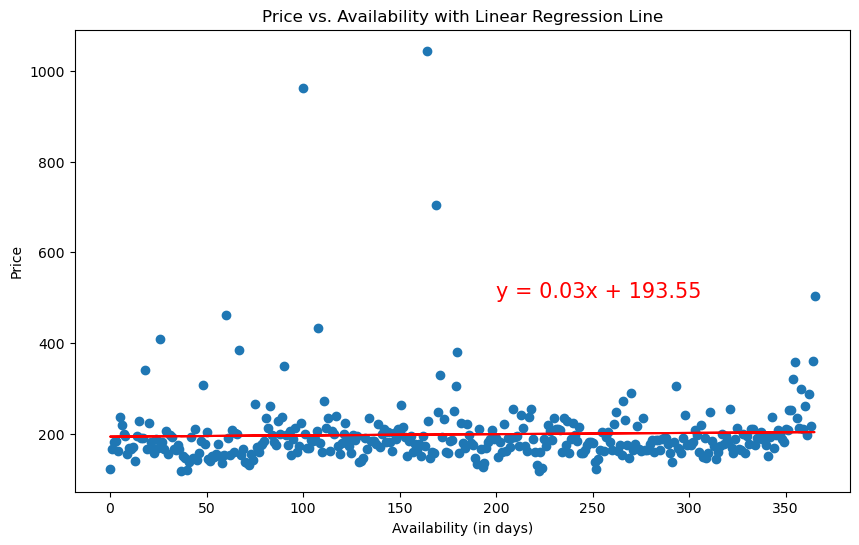

In [19]:
# Add the linear regression equation and line to the plot
availability = data.groupby('availability_365')['price'].agg(['mean', 'median', 'min', 'max']).reset_index()
availability = availability.sort_values(by='mean', ascending=False)
x_values = availability['availability_365']
y_values = availability['mean']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values)
plt.plot(x_values, regress_values, "r-")
plt.annotate(line_eq, (200, 500), fontsize=15, color="red")
plt.xlabel('Availability (in days)')
plt.ylabel('Price')
plt.title('Price vs. Availability with Linear Regression Line')
plt.show()

**What this shows**:The scatter plot exhibits a moderately positive correlation between price and availability. As the number of available days increases, there is a tendency for prices to rise. Despite the overall positive correlation, the data points on the scatter plot are still somewhat scattered. This means that while there is a general trend of increasing prices with more availability, there are exceptions, and other factors can influence pricing decisions.
It's important to note that there is a wide range of prices for any given level of availability. In other words, availability alone does not account for all variations in price. Other factors, such as location, property type, and amenities, likely play a substantial role in determining pricing.
In conclusion, the scatter plot and the regression line equation provide evidence of a moderately positive correlation between the price of Airbnb listings and their availability. While the regression line suggests that increased availability tends to be associated with slightly higher prices, there is still a degree of variability, and other factors are also influential.


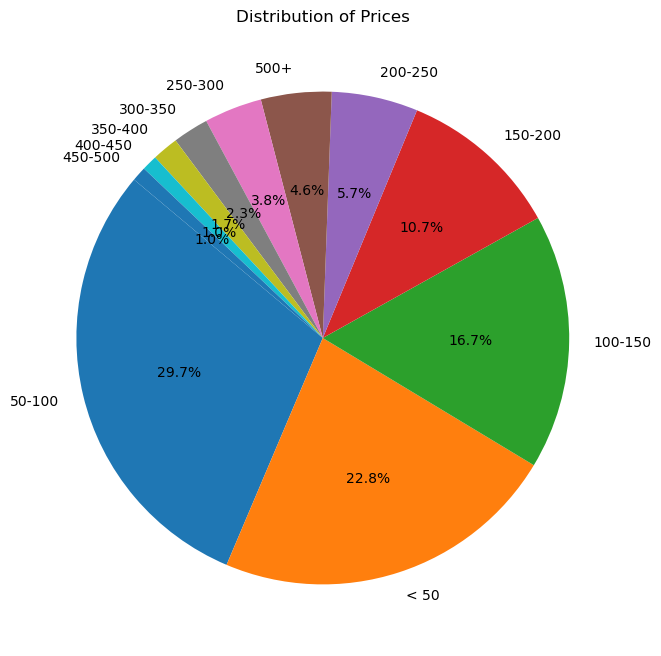

In [20]:
# Define price bins
price_bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, np.inf]
price_labels = ['< 50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350', '350-400', '400-450', '450-500', '500+']

# Create a new column 'price_category' based on price bins
data['price_category'] = pd.cut(data['price'], bins=price_bins, labels=price_labels)

# Calculate the distribution of prices by category
price_distribution = data['price_category'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(price_distribution, labels=price_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Prices')
plt.show()
